# Benchmarking Linear Regression and Logistic Regression

Benchmarking linear and logistic regression on Concrete ML for FHE. The code is profiled and memory and time performance is reported on the outputs of the cells and the project report.



## Installation

In [3]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 56.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of onnxconverter-common to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/17

In [1]:
!pip install memory_profiler
!pip install psutil

In [2]:
!pip install memory_profiler

## Linear Regression

In [9]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LinearRegression as conLinearRegression
from sklearn.linear_model import LinearRegression

import numpy as np
import psutil

In [10]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LinearRegression as conLinearRegression
from sklearn.linear_model import LinearRegression

import numpy as np
import time

# Dataset from sklearn
x, y = make_regression(n_samples=1000, n_features=30, random_state=42, noise=10)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Encrypted model
model = conLinearRegression(n_bits=4)
model.fit(X_train, y_train)

model.compile(X_train)

t1 = time.perf_counter()
y_pred_fhe = model.predict(X_test, fhe="execute")
t2 = time.perf_counter()


# Regular sklearn model
model2 = LinearRegression()
model2.fit(X_train, y_train)

t3 = time.perf_counter()
y_pred_clear = model2.predict(X_test)
t4 = time.perf_counter()

print("Without HE: time taken: ",t4-t3)
print("With HE: time taken: ",t2-t1)


Without HE: time taken:  0.00023156999986895244
With HE: time taken:  0.7830154510002103


In [12]:
# Initialize total time for each mode
total_times = {'simulate': 0, 'disable': 0, 'execute': 0}

# Run the loop 10 times for each mode
for _ in range(10):
    start_time = time.process_time()
    y_pred_fhe = model.predict(X_test[0], fhe='simulate')
    end_time = time.process_time()
    total_times['simulate'] += (end_time - start_time)

    start_time = time.process_time()
    y_pred_fhe = model.predict(X_test[0], fhe='disable')
    end_time = time.process_time()
    total_times['disable'] += (end_time - start_time)

    start_time = time.process_time()
    y_pred_fhe = model.predict(X_test[0], fhe='execute')
    end_time = time.process_time()
    total_times['execute'] += (end_time - start_time)

# Calculate the average time taken for each mode
average_times = {mode: total_time / 10 for mode, total_time in total_times.items()}

print("Average time per mode:")
for mode, avg_time in average_times.items():
    print(f"{mode}: {avg_time}")

Average time per mode:
simulate: 0.0009450376000074811
disable: 0.0001822458999868104
execute: 0.006100682400000323


In [6]:
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

# Calculating R^2 scores
r2_fhe = r2_score(y_test, y_pred_fhe)
r2_clear = r2_score(y_test, y_pred_clear)

print("R^2 score without HE:", r2_clear)
print("R^2 score with HE:", r2_fhe)

R^2 score without HE: 0.9973174354344188
R^2 score with HE: 0.9692797447327586


0.0006279199999994489


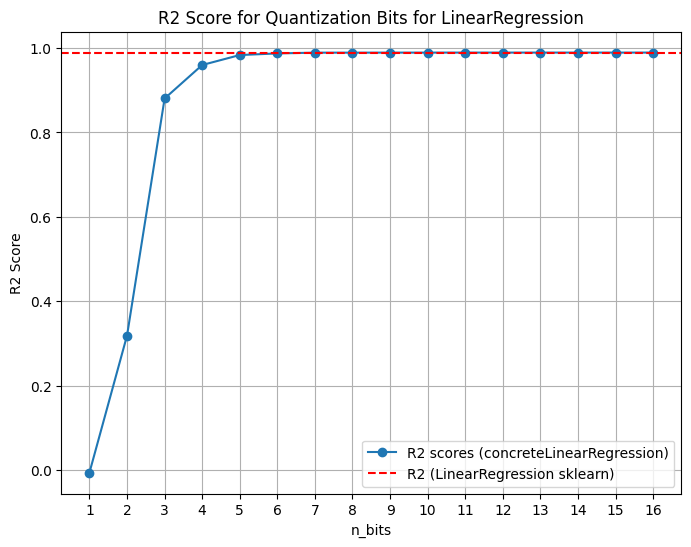

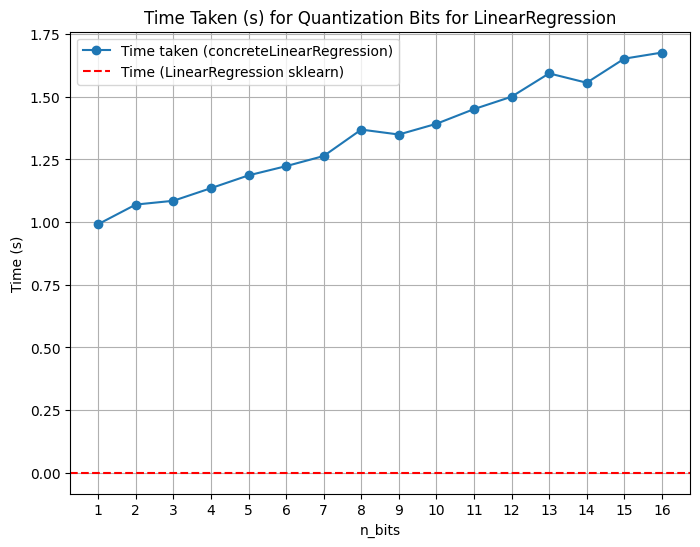

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


x, y = make_regression(n_samples=1000, n_features=30, random_state=42, noise=20)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train model2 (constant model)
model2 = LinearRegression()
model2.fit(X_train, y_train)
t1 = time.process_time()
y_pred_clear = model2.predict(X_test)
t2 = time.process_time()
time_taken_og = t2 - t1
print(time_taken_og)

# Varying n_bits for conLinearRegression model
n_bits_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
#n_bits_values = [1, 3, 6]
r2_scores = []
mse_scores = []
times = []

for n_bits in n_bits_values:
    # Test conLinearRegression model with different n_bits values
    model = conLinearRegression(n_bits=n_bits)
    model.fit(X_train, y_train)
    model.compile(X_train)

    time_taken = 0.0
    for it in range(10):
      t1 = time.process_time()
      y_pred_fhe = model.predict(X_test, fhe="execute")
      t2 = time.process_time()

      time_taken +=  t2 - t1
    times.append(time_taken/10)

    # Calculate R^2 and MSE scores
    r2 = r2_score(y_test, y_pred_fhe)
    mse = mean_squared_error(y_test, y_pred_fhe)

    r2_scores.append(r2)
    mse_scores.append(mse)


# Plotting R^2 scores
plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, r2_scores, marker='o', label='R2 scores (concreteLinearRegression)')
plt.axhline(y=r2_score(y_test, y_pred_clear), color='r', linestyle='--', label='R2 (LinearRegression sklearn)')
plt.xlabel('n_bits')
plt.ylabel('R2 Score')
plt.title('R2 Score for Quantization Bits for LinearRegression')
plt.xticks(n_bits_values)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, times, marker='o', label='Time taken (concreteLinearRegression)')
plt.axhline(y=time_taken_og, color='r', linestyle='--', label='Time (LinearRegression sklearn)')
plt.xlabel('n_bits')
plt.ylabel('Time (s)')
plt.title('Time Taken (s) for Quantization Bits for LinearRegression')
plt.xticks(n_bits_values)
plt.legend()
plt.grid(True)
plt.show()


### Memory Profiling

In [6]:
%reload_ext memory_profiler

In [18]:
import sys
sys.getsizeof(model)

48

In [10]:
%%file mmmmmmprunnn_demo.py

from concrete.ml.sklearn import LinearRegression as conLinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


def maain(X_train, y_train, X_test):

  n_bits = 4
  for m in range(1):
      model = conLinearRegression(n_bits=n_bits)

      model.fit(X_train, y_train)
      model.compile(X_train)

      y_pred_fhe = model.predict(X_test, fhe="execute")

      for i in range(len(X_test)):
          q_input = model.quantize_input(X_test[[i]])

          # Encrypt the input
          q_input_enc = model.fhe_circuit.encrypt(q_input)

          # Execute the linear product in FHE
          q_y_enc = model.fhe_circuit.run(q_input_enc)

          # Decrypt the result (integer)
          q_y = model.fhe_circuit.decrypt(q_y_enc)

          # De-quantize and post-process the result
          y0 = model.post_processing(model.dequantize_output(q_y))
      del model

Writing mmmmmmprunnn_demo.py


In [19]:
# for i in range(16):
#   %memit fhe_inference_linear(n_bits = i)


from mmmmmmprunnn_demo import maain
x, y = make_regression(n_samples=10000, n_features=30, random_state=42, noise=20)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

%mprun -f maain maain(X_train, y_train, X_test)

In [22]:
%%file mprun_demooo.py
def sum_of_lists(N):
    total = 0
    for i in range(5):
        a = 0
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
        del L # remove reference to L
    return total

Overwriting mprun_demooo.py


In [24]:
from mprun_demooo import sum_of_lists
%mprun -f sum_of_lists sum_of_lists(100)

## Logistic Regression

In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression as conLogisticRegression
from sklearn.linear_model import LogisticRegression

import numpy as np
import time

# Dataset from sklearn
x, y = make_classification(n_samples=1000, n_features=30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Train the HE model
model = conLogisticRegression(n_bits=4)
model.fit(X_train, y_train)

# Compile on a representative set -- I don't understand this
model.compile(X_train)

t1_log = time.perf_counter()
# Run the inference on encrypted inputs
y_pred_fhe = model.predict(X_test, fhe="execute")
t2_log = time.perf_counter()


# Added part - Beste
# Regular Linear Regression without HE from sklearn
model2 = LogisticRegression()
model2.fit(X_train, y_train)

t3_log = time.perf_counter()
# We can simulate the predictions in the clear
y_pred_clear = model2.predict(X_test)
t4_log = time.perf_counter()


print("Without HE  :", y_pred_clear,"and Time taken: ",t4_log-t3_log)
print("With HE    :", np.array(y_pred_fhe).T,"and Time taken: ",t2_log-t1_log)


Without HE  : [0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0
 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0
 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1] and Time taken:  0.00028984000027776347
With HE    : [0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0
 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0
 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1
 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0
 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0
 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1] and Time taken:  0.7260159279999243


In [2]:
from sklearn.metrics import mean_squared_error

from sklearn.metrics import f1_score

# Calculating R^2 scores
r2_fhe = f1_score(y_test, y_pred_fhe)
r2_clear = f1_score(y_test, y_pred_clear)

print("f1 score without HE:", r2_clear)
print("f1 score with HE:", r2_fhe)

f1 score without HE: 0.824858757062147
f1 score with HE: 0.7999999999999999


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from concrete.ml.sklearn import LogisticRegression as conLogisticRegression


x, y = make_classification(n_samples=1000, n_features=30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train model2 (constant model)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
t1 = time.process_time()
y_pred_clear = model2.predict(X_test)
t2 = time.process_time()
time_taken_og = t2 - t1
print(time_taken_og)

# Varying n_bits for conLinearRegression model
n_bits_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
#n_bits_values = [1, 3, 6]
f1_scores = []
times = []

for n_bits in n_bits_values:
    # Test conLinearRegression model with different n_bits values
    model = conLogisticRegression(n_bits=n_bits)
    model.fit(X_train, y_train)
    model.compile(X_train)
    print(n_bits)
    time_taken = 0.0
    for it in range(10):
      t1 = time.process_time()
      y_pred_fhe = model.predict(X_test, fhe="execute")
      t2 = time.process_time()

      time_taken +=  t2 - t1
    times.append(time_taken/5)

    # Calculate R^2 and MSE scores
    f1 = f1_score(y_test, y_pred_fhe)

    f1_scores.append(f1)





0.0004977210000021159
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


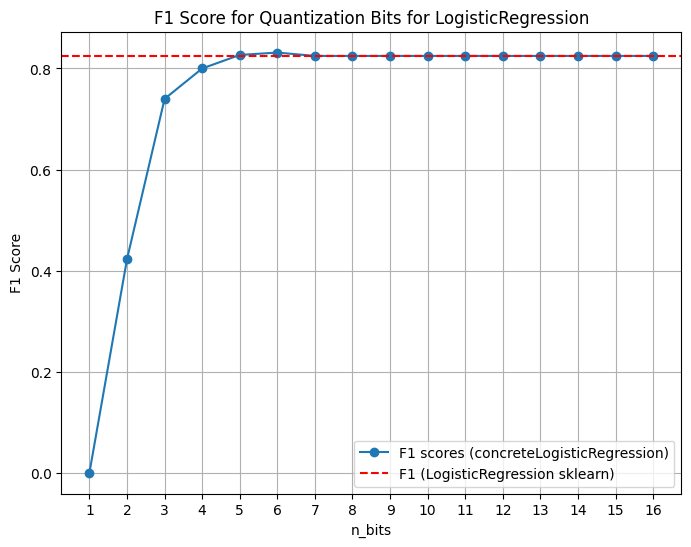

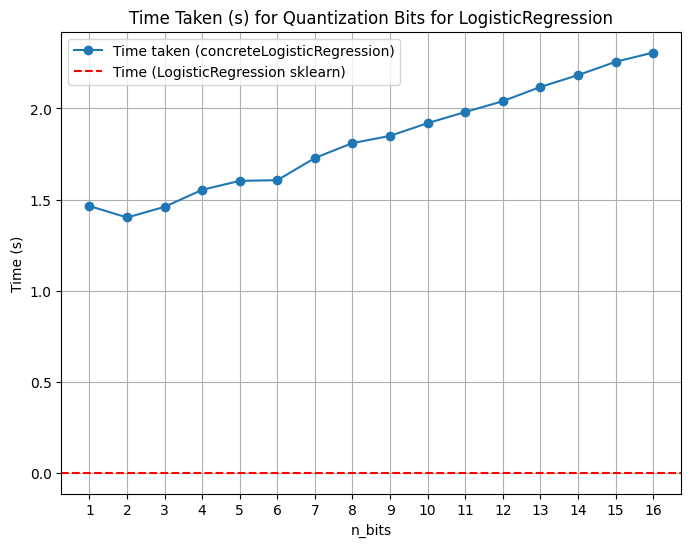

In [6]:
# Plotting R^2 scores
plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, f1_scores, marker='o', label='F1 scores (concreteLogisticRegression)')
plt.axhline(y=f1_score(y_test, y_pred_clear), color='r', linestyle='--', label='F1 (LogisticRegression sklearn)')
plt.xlabel('n_bits')
plt.ylabel('F1 Score')
plt.title('F1 Score for Quantization Bits for LogisticRegression')
plt.xticks(n_bits_values)
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(n_bits_values, times, marker='o', label='Time taken (concreteLogisticRegression)')
plt.axhline(y=time_taken_og, color='r', linestyle='--', label='Time (LogisticRegression sklearn)')
plt.xlabel('n_bits')
plt.ylabel('Time (s)')
plt.title('Time Taken (s) for Quantization Bits for LogisticRegression')
plt.xticks(n_bits_values)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Initialize total time for each mode
total_times = {'simulate': 0, 'disable': 0, 'execute': 0}

# Run the loop 10 times for each mode
for _ in range(10):
    start_time = time.process_time()
    y_pred_fhe = model.predict(X_test[0], fhe='simulate')
    end_time = time.process_time()
    total_times['simulate'] += (end_time - start_time)

    start_time = time.process_time()
    y_pred_fhe = model.predict(X_test[0], fhe='disable')
    end_time = time.process_time()
    total_times['disable'] += (end_time - start_time)

    start_time = time.process_time()
    y_pred_fhe = model.predict(X_test[0], fhe='execute')
    end_time = time.process_time()
    total_times['execute'] += (end_time - start_time)

# Calculate the average time taken for each mode
average_times = {mode: total_time / 10 for mode, total_time in total_times.items()}

print("Average time per mode:")
for mode, avg_time in average_times.items():
    print(f"{mode}: {avg_time}")

Average time per mode:
simulate: 0.0009135526999983767
disable: 0.00027689119999934063
execute: 0.0042944628000043394


## Internal profiling of the models

In [ ]:
q_input = model.quantize_input(X_test[[0]])

# Encrypt the input
q_input_enc = model.fhe_circuit.encrypt(q_input)

# Execute the linear product in FHE
q_y_enc = model.fhe_circuit.run(q_input_enc)

# Decrypt the result (integer)
q_y = model.fhe_circuit.decrypt(q_y_enc)

# De-quantize and post-process the result
y0 = model.post_processing(model.dequantize_output(q_y))

In [ ]:
import time
model = conLogisticRegression(n_bits=4)
model.fit(X_train, y_train)

# Compile on a representative set -- I don't understand this
model.compile(X_train)


# Initialize total time for each line
total_times = [0] * 5

# Run the loop 10 times
for _ in range(10):
    start_time = time.process_time()
    q_input = model.quantize_input(X_test[[0]])
    end_time = time.process_time()
    total_times[0] += (end_time - start_time)

    start_time = time.process_time()
    q_input_enc = model.fhe_circuit.encrypt(q_input)
    end_time = time.process_time()
    total_times[1] += (end_time - start_time)

    start_time = time.process_time()
    q_y_enc = model.fhe_circuit.run(q_input_enc)
    end_time = time.process_time()
    total_times[2] += (end_time - start_time)

    start_time = time.process_time()
    q_y = model.fhe_circuit.decrypt(q_y_enc)
    end_time = time.process_time()
    total_times[3] += (end_time - start_time)

    start_time = time.process_time()
    y0 = model.post_processing(model.dequantize_output(q_y))
    end_time = time.process_time()
    total_times[4] += (end_time - start_time)

# Calculate the average time taken per line
average_times = [total_time / 10 for total_time in total_times]

print("Average time per line:")
print("Quantize input:", average_times[0])
print("Encrypt input:", average_times[1])
print("Execute linear product:", average_times[2])
print("Decrypt result:", average_times[3])
print("De-quantize and post-process result:", average_times[4])
